# LangGraph Compatible LLMs

- Create OpenAI style LLMs using almost any LLM.
- These LLMs can be used in LangGraph workflows.

In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    Type,
    TypedDict,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=1)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


### LangGraph imports

In [ ]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_core.tools import InjectedToolCallId, tool
from langchain_tavily import TavilySearch
from langfuse.langchain import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

### Define Schemas (Pydantic Models), States

In [5]:
from openai import AsyncOpenAI
from pydantic import BaseModel, BeforeValidator, Field


class MessageState(TypedDict):
    """State for storing messages in the conversation."""

    messages: Annotated[list[AnyMessage], add_messages]

### Prompts

In [6]:
system_msg: str = """
<system>
/no_think

<role>
You are a helpful assistant that answers user queries in a friendly and concise manner. 
</role>

</system>
"""

### Helper Functions

In [7]:
def convert_to_openai_messages(messages: list[AnyMessage]) -> list[dict[str, Any]]:
    """
    Convert a list of messages to OpenAI compatible message format.

    Parameters
    ----------
    messages : list[AnyMessage]
        List of messages to be converted. Can contain SystemMessage,
        AIMessage, ToolMessage, or other message types.

    Returns
    -------
    list[dict[str, Any]]
    """
    formatted: list[dict[str, Any]] = []

    for msg in messages:
        if isinstance(msg, SystemMessage):
            formatted.append({"role": "system", "content": msg.content})
        elif isinstance(msg, AIMessage):
            formatted.append({"role": "assistant", "content": msg.content})
        elif isinstance(msg, ToolMessage):
            formatted.append(
                {
                    "role": "tool",
                    "content": msg.content,
                    "tool_call_id": msg.tool_call_id,
                }
            )
        else:
            formatted.append({"role": "user", "content": msg.content})
    return formatted

In [8]:
# Test the function
test_messages: list[AnyMessage] = [
    SystemMessage(content="You are a helpful assistant."),
    HumanMessage(content="What is the capital of France?"),
    AIMessage(content="The capital of France is Paris."),
]
formatted_messages = convert_to_openai_messages(test_messages)
formatted_messages

[{'role': 'system', 'content': 'You are a helpful assistant.'},
 {'role': 'user', 'content': 'What is the capital of France?'},
 {'role': 'assistant', 'content': 'The capital of France is Paris.'}]

In [9]:
# Create Nodes


async def chatbot(state: MessageState) -> dict[str, Any]:
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    formatted_messages = convert_to_openai_messages(messages)
    aclient = AsyncOpenAI(
        api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
        base_url=settings.OPENROUTER_URL,
        max_retries=3,
    )
    response = await aclient.chat.completions.create(
        model=ModelEnum.LLAMA_3p2_1B_INSTRUCT_REMOTE.value,
        messages=formatted_messages,
        temperature=0.0,
        seed=1,
    )
    content = response.choices[0].message.content

    return {"messages": [AIMessage(content=content)]}

In [10]:
messages: list[AnyMessage] = [
    HumanMessage(content="What is the capital of Nigeria?"),
]
await chatbot({"messages": messages})

{'messages': [AIMessage(content='The capital of Nigeria is Abuja.', additional_kwargs={}, response_metadata={})]}

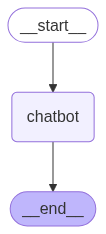

In [13]:
graph_builder = StateGraph(MessageState)

# Add nodes
graph_builder.add_node("chatbot", chatbot)

# Connect nodes
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Add memory
within_thread_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=within_thread_memory).with_config(
    run_name="simple-chatbot"
)

# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
message: str = "What is the capital of Nigeria?"
input_state = MessageState(messages=[message])

config: dict[str, dict[str, str]] = {"configurable": {"thread_id": "1"}}

# Run the graph
async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

What is the capital of Nigeria?
================================ Human Message =================================

What is the capital of Nigeria?
================================== Ai Message ==================================

The capital of Nigeria is Abuja.


In [15]:
# Chat history
state = graph.get_state(config=config).values

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the capital of Nigeria?
================================== Ai Message ==================================

The capital of Nigeria is Abuja.
